In [23]:
import nltk
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [24]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [26]:
import re
import numpy as np

In [27]:
import pickle

In [28]:
files=[
       'anger-ratings-0to1.train.txt',
       'fear-ratings-0to1.train.txt',
       'joy-ratings-0to1.train.txt',
       'sadness-ratings-0to1.train.txt',
       'anger-ratings-0to1.dev.gold.txt',
       'fear-ratings-0to1.dev.gold.txt',
       'joy-ratings-0to1.dev.gold.txt',
       'sadness-ratings-0to1.dev.gold.txt',
        'anger-ratings-0to1.test.gold.txt',
        'sadness-ratings-0to1.test.gold.txt',
        'joy-ratings-0to1.test.gold.txt',
        'fear-ratings-0to1.test.gold.txt'
]

In [29]:
def read_data(files):
    x=[]
    y=[]
    threshold=0.5
    for file in files:
      corpus = open(file).read().lower().split('\n')
      del corpus[-1]
      for line in corpus:
        line= line.split('\t') #seperate parts
        intensity= line[-1]
        if float(intensity)>threshold:
          x.append(line[1])
          y.append(line[2])
    return x,y

In [30]:
def clean_text(text):
    text = ' '.join([x for x in text.split() if x[0]!='@'])
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

In [31]:
x,y = read_data(files)
x = [clean_text(text) for text in x]

In [32]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

In [33]:
from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy = train_test_split(x,y,test_size=0.33, stratify=y)

In [34]:
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(trainx)
word_index= tokenizer.word_index
vocab_size = len(word_index)+1

In [35]:
x_train_seq = tokenizer.texts_to_sequences(trainx)
max_seq_len= max([len(x) for x in x_train_seq])
x_train = pad_sequences(x_train_seq, maxlen= max_seq_len, truncating= 'post', padding= 'post')
x_test_seq = tokenizer.texts_to_sequences(testx)
x_test = pad_sequences(x_test_seq, maxlen= max_seq_len, truncating= 'post', padding= 'post')

In [36]:
classes= set(y)
class_to_index= dict((c,i) for i,c in enumerate(classes))
index_to_class= dict((v,k) for k,v in class_to_index.items())
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [37]:
y_train = names_to_ids(trainy)
y_test = names_to_ids(testy)

In [38]:
x_test = np.array(x_test)
x_train = np.array(x_train)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [39]:
with open("tok.pickle", "wb") as f:
    pickle.dump((tokenizer, max_seq_len, index_to_class), f)

## MODEL 1

In [111]:
'''model= tf.keras.models.Sequential([
       tf.keras.layers.Embedding(vocab_size,16,input_length= max_seq_len),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
       tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
h= model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)'''

## MODEL 2

In [115]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_seq_len),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
h= model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Train on 2207 samples, validate on 1088 samples
Epoch 1/100
2207/2207 [==============================] - 1s 377us/sample - loss: 1.3766 - accuracy: 0.3163 - val_loss: 1.3673 - val_accuracy: 0.3162
Epoch 2/100
2207/2207 [==============================] - 0s 134us/sample - loss: 1.3206 - accuracy: 0.3181 - val_loss: 1.2442 - val_accuracy: 0.3483
Epoch 3/100
2207/2207 [==============================] - 0s 120us/sample - loss: 0.9464 - accuracy: 0.6257 - val_loss: 0.6185 - val_accuracy: 0.8272
Epoch 4/100
2207/2207 [==============================] - 0s 138us/sample - loss: 0.2788 - accuracy: 0.9388 - val_loss: 0.3744 - val_accuracy: 0.8713
Epoch 5/100
2207/2207 [==============================] - 0s 127us/sample - loss: 0.0982 - accuracy: 0.9733 - val_loss: 0.3691 - val_accuracy: 0.8713
Epoch 6/100
2207/2207 [==============================] - 0s 119us/sample - loss: 0.0566 - accuracy: 0.9823 - val_loss: 0.3802 - val_accuracy: 0.8759
Epoch 7/100
2207/2207 [==============================] - 0

In [117]:
%matplotlib inline

import matplotlib.pyplot as plt
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

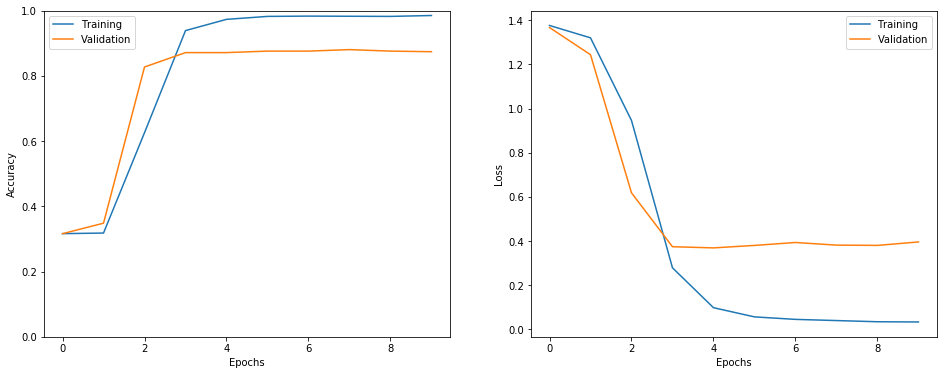

In [118]:
show_history(h)

In [155]:
sen='i lost my beloved pet'
sen= clean_text(sen)
seq= tokenizer.texts_to_sequences([sen])
pad= pad_sequences(seq, maxlen=max_seq_len, padding='post', truncating='post')
p=model.predict(pad)[0]
psent= index_to_class[np.argmax(p).astype('int8')]
psent

'sadness'

## SAVE

In [150]:
import os.path
if os.path.isfile('model.h5') is False:
    model.save('model.h5')

## LOAD

In [40]:
from tensorflow.keras.models import load_model
new_model= load_model('model.h5')

In [50]:
sen='i lost a beloved pet'
sen= clean_text(sen)
seq= tokenizer.texts_to_sequences([sen])
pad= pad_sequences(seq, maxlen=max_seq_len, padding='post', truncating='post')
p=new_model.predict(pad)[0]
psent= index_to_class[np.argmax(p).astype('int8')]
psent

'sadness'